In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp profile

# Profile

> Set of functions for calculating roughness parameters along profiles 

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis, moment
from scipy.signal import find_peaks
import math

from rough.data import *


To demonstrate, we're going to build on the data we processed in `data` 

In [ ]:
image = np.loadtxt('example.txt')
profiles = np.loadtxt('example_profiles.txt')

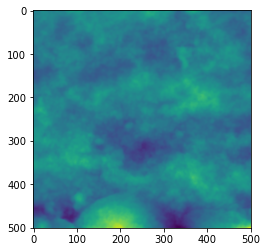

In [ ]:
plt.imshow(image)
plt.show()

## Statistical Parameters
The following methods are statistical in nature, providing a single number as a broad description of the distribution of the height values. 

In [ ]:
#| export
def Ra(im, #Numpy array or arraylike
       axis = 1, #Default to Ra of rows
       norm = True #Normalize the profile by subtracting the mean 
      ):
    '''
    Calculates Mean Absolute Roughness (Ra) along given axis. Defined as the average deviation of absolute height values from the mean line.
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.mean(np.absolute(im), axis = axis)

In [ ]:
Ra(image)[:5]

array([0.00042114, 0.0004146 , 0.00040444, 0.00039162, 0.00037649])

Remember, if you just want the parameters of a certain profile, you just index into your image and be mindful of the axis. 

In [ ]:
first_row_profile    = image[0,:]
first_column_profile = image[:,0]
Ra(first_column_profile, axis = 0)

0.00043905629459996097

In [ ]:
#| export
def Rms(im, #Numpy array or array like
        axis = 1, #Default to Rms of rows
        norm = True #Normalize the profile by subtracting the mean
       ):
    '''
    Calculates Root Mean Square Roughness (Rms) along given axis. Defined as the root mean square of deviations of height from the mean line of a given profile. 
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.sqrt(np.mean(np.square(im), axis = axis))

In [ ]:
Rms(image)[:5]

array([0.0005232 , 0.00051211, 0.00049625, 0.00047939, 0.00046217])

In [ ]:
#| export
def Rsk(im, #Numpy array or array like
         axis = 1, #Default to Skew of rows
         norm = True, #Normalize the profile by subtracting the mean
        **kwargs #Keyword arguments to modify the skew function
       ):
    '''
    Calcultes the Skew (Rsk) along given axis. Thin wrapper around scipy.stats.skew with bias set to False
    '''
    if norm:
        im = im - np.mean(im, axis=axis, keepdims=True)
    return skew(a = im, axis=axis, **kwargs)

In [ ]:
Rsk(image)[:5]

array([-0.34102473, -0.34162509, -0.33785933, -0.32203996, -0.2844012 ])

In [ ]:
#| export
def Rku(im, #Numpy array or array like
       axis = 1, #Default to Kurtosis of rows
       norm= True, #Normalize the profile by subtracting the mean
        **kwargs #Keyword arguments to modify the kurtosis function
       ):
    '''
    Calculates the Kurtosis (Rku) along given axis. This wrapper around scipy.stats.kurtosis 
    '''
    if norm:
        im = im - np.mean(im,axis=axis, keepdims=True)
    return kurtosis(a = im, axis = axis, **kwargs)

In [ ]:
Rku(image)[:5]

array([-0.67518082, -0.7123575 , -0.75156931, -0.76424118, -0.74213074])

In [ ]:
#| export
def Rp(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.amax function
         ):
    '''
    Calculates the peak height of the profile. 
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.amax(im, axis = axis, **kwargs)
    

In [ ]:
#| export
def Rv(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.amin function
         ):
    '''
    Calculates the absolute max valley depth of the profile. 
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
        
    return abs(np.amin(im, axis = axis, **kwargs))

In [ ]:
#| export
def Rz(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.ptp function
         ):
    '''
    Calculates the maximum height (max height + absolute max depth) of the profile. Synonymous with range. 
    Also called Rt
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    
    return np.ptp(im,axis = axis, **kwargs)

In [ ]:
## Texture Parameters


In [ ]:
def local_max_min(im,
                  axis = 1,
                  norm = True,
                  **kwargs
                 ):
    ''' 
    Returns the number of local maxima and minima per unit length, also known as the density of extremes from Nayak (1971).
    Assumes the surface is random, with a gaussian distribution of heights (usually pretty safe). 
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    
    m2 = moment(im, moment=2, axis = axis)
    m4 = moment(im, moment=4, axis = axis)
    return (1/math.pi) * ((m4/m2)**(1/2))
    

In [ ]:
def Sds(im,
        axis = 1,
        norm = True,
        **kwargs
       ):
    '''
    Density of summits, as described by Nayak (1971)
    '''
    m2 = moment(im, moment=2, axis = axis)
    m4 = moment(im, moment=4, axis = axis)
    
    return (1 / (6 * math.pi * (3**(1/2)))) * (m4/m2)

In [ ]:
Sds(image)

array([1.94925116e-08, 1.83759885e-08, 1.69600203e-08, 1.57376224e-08,
       1.47721105e-08, 1.41187821e-08, 1.37611040e-08, 1.34290580e-08,
       1.29276764e-08, 1.23666839e-08, 1.18297973e-08, 1.13012382e-08,
       1.06949448e-08, 9.96241817e-09, 9.20056523e-09, 8.54169206e-09,
       8.13197494e-09, 7.92167484e-09, 7.72233601e-09, 7.44147308e-09,
       7.20464056e-09, 7.16168132e-09, 7.30183438e-09, 7.48230718e-09,
       7.66921800e-09, 7.88896781e-09, 8.06797688e-09, 8.07306313e-09,
       7.92745200e-09, 7.70990169e-09, 7.52410251e-09, 7.52048515e-09,
       7.74437594e-09, 8.06943248e-09, 8.25553321e-09, 8.20078847e-09,
       7.98095757e-09, 7.69064353e-09, 7.44539834e-09, 7.28363005e-09,
       7.15245870e-09, 7.04371614e-09, 6.98843369e-09, 7.03629638e-09,
       7.18705409e-09, 7.35724872e-09, 7.39625415e-09, 7.27723207e-09,
       7.14163420e-09, 7.07995996e-09, 7.06053345e-09, 7.11344971e-09,
       7.26294110e-09, 7.37932950e-09, 7.36470777e-09, 7.29613438e-09,
      

In [ ]:
from scipy.stats import norm

In [ ]:
norm.stats(moments='mvsk')

(array(0.), array(1.), array(0.), array(0.))

In [ ]:
loc, scale = norm.fit(image[0])

In [ ]:
pdf = norm.pdf(image[0],loc=loc,scale=scale)
cdf = norm.cdf(image[0],loc=loc,scale=scale)

[<matplotlib.lines.Line2D>]

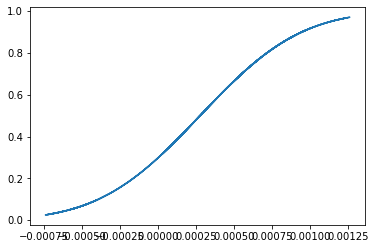

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(image[0],cdf)

(array([26., 10., 22., 20., 11.,  8.,  3.,  2.,  3.,  4.,  6., 16., 31.,
        37., 23., 26., 20., 30., 28., 43., 21., 17., 10., 11., 23., 15.,
         9.,  6.,  8., 12.]),
 array([-7.41222638e-04, -6.74375644e-04, -6.07528649e-04, -5.40681655e-04,
        -4.73834661e-04, -4.06987667e-04, -3.40140673e-04, -2.73293679e-04,
        -2.06446684e-04, -1.39599690e-04, -7.27526960e-05, -5.90570179e-06,
         6.09412924e-05,  1.27788287e-04,  1.94635281e-04,  2.61482275e-04,
         3.28329269e-04,  3.95176263e-04,  4.62023257e-04,  5.28870252e-04,
         5.95717246e-04,  6.62564240e-04,  7.29411234e-04,  7.96258228e-04,
         8.63105223e-04,  9.29952217e-04,  9.96799211e-04,  1.06364621e-03,
         1.13049320e-03,  1.19734019e-03,  1.26418719e-03]),
 <BarContainer object of 30 artists>)

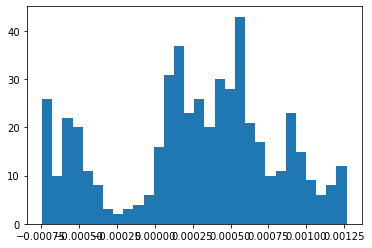

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(image[0],bins=30)

[<matplotlib.lines.Line2D>]

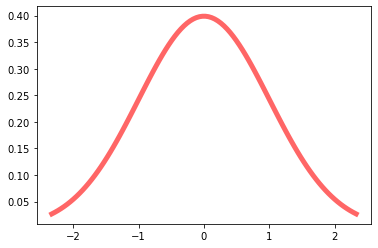

In [ ]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),

                norm.ppf(0.99), 100)

ax.plot(x, norm.pdf(x),

       'r-', lw=5, alpha=0.6, label='norm pdf')

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()